# Pytorch MNIST Test
Copied from https://github.com/pytorch/examples/blob/master/mnist/main.py
* Get pytorch working, try out on MNIST.
* Try a few learning rate schedules.

In [1]:
import os
import sys
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score
% matplotlib inline


import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

# Import modules every time you run code imported using %aimport
%load_ext autoreload
%autoreload 1

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
%aimport functions
from functions import*

base_data_dir = '/home/rbbidart/project/rbbidart/learn-lr/data'
cuda = 'True'
seed = 101
batch_size = 64
test_batch_size = 64

/home/rbbidart/learn-lr/src


In [2]:
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)    
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

## Data Loaders
* How are the transforms done? Like every time a batch is generated? Or are they applied and cashed somehow? Pretty sure it is just when the batch is generated.

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(base_data_dir, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(base_data_dir, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
def train(epoch, log_interval=10):
    hist = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            hist.append(loss.data[0])
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    return(hist)

def test(log_interval=10):
    model.eval()
    test_loss = 0
    correct = 0
    hist = {}
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    hist['acc'] = 100. * correct / len(test_loader.dataset)
    hist['loss'] = test_loss
    return(hist)

In [6]:
lr = .01
momentum = .5
epochs = 10

model = Net()
if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_loss = []
performance_test = {}

for epoch in range(1, epochs + 1):
    train_loss = train(epoch, log_interval=200)
    test_hist = test(log_interval=100)
    train_loss.append(train_loss)
    performance_test.update(test_hist)

/home/rbbidart/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303757
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.150467
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.726568
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.617588
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.331238

Test set: Average loss: 0.2051, Accuracy: 9396/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.345476
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.339804
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.303642
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.702417
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.525882

Test set: Average loss: 0.1216, Accuracy: 9636/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.350017
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.273935
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.268314
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.382894
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.251779

Test set: Average loss: 0.0917, Accuracy: 9705/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.218105
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [7]:
print(train_loss)
print(performance_test)

[Variable containing:
1.00000e-02 *
  7.9735
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, Variable containing:
 0.1120
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, Variable containing:
 0.1473
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, Variable containing:
 0.2540
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, Variable containing:
 0.1119
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, [...]]
{'acc': 98.51, 'loss': 0.05052068002223969}


# Use proper validation set
# ###############
##


In [5]:
import torch.utils.data.sampler as sampler
def MNIST_data_loaders(base_data_dir, train_samples_index, valid_samples_index, batch_size=64):
    """Make train, validation, test data loaders for MNIST dataset.
    Limited augmnetation and nothing fancy
    Arguments:
        num_valid_samples: # of desired datapoints
        start: offset where we should start selecting from  (less than )      
    """
    class ChunkSampler(sampler.Sampler):
        """Samples elements sequentially from some offset. 
        Argument:
            samples_index: index of desired samples
        """
        def __init__(self, samples_index):
            self.samples_index = samples_index

        def __iter__(self):
            return iter(self.samples_index)
    
        def __len__(self):
            return len(self.samples_index)

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(base_data_dir, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.RandomRotation(15),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, **kwargs,
        sampler=ChunkSampler(train_samples_index))

    valid_loader = torch.utils.data.DataLoader(
        datasets.MNIST(base_data_dir, train=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, **kwargs,
        sampler=ChunkSampler(valid_samples_index))


    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(base_data_dir, train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    return(train_loader, valid_loader, test_loader)

In [6]:
indexes = list(range(60000))
random.shuffle(indexes)
valid_frac = .2
train_samples_index = indexes[int(valid_frac*len(indexes)):]
valid_samples_index = indexes[0:int(valid_frac*len(indexes))]

train_loader, valid_loader, test_loader = MNIST_data_loaders(base_data_dir, train_samples_index, valid_samples_index, batch_size=64)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
def train(epoch, log_interval=10):
    hist = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            hist.append(loss.data[0])
    return(hist)

def valid(log_interval=10):
    model.eval()
    valid_loss = 0
    correct = 0
    hist = {}
    for data, target in valid_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    valid_loss /= len(valid_loader.dataset)
    hist['acc'] = 100. * correct / len(valid_loader.dataset)
    hist['loss'] = valid_loss
    return(hist)

def test():
    model.eval()
    test_loss = 0
    correct = 0
    hist = {}
    
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    hist['acc'] = 100. * correct / len(test_loader.dataset)
    hist['loss'] = test_loss
    return(hist)

In [10]:
def test_lr_schedules(model, optimizer, schedulers, train, test, valid, epochs):
    """ Input is a list of schedulers"""
    # order of samples is not changed between epochs
    if cuda:
        model.cuda()
        
    # Create dicts for everything we care about 
    lr_list = {}
    train_loss = {}
    valid_loss = {}
    valid_acc = {}
    test_loss = {}
    test_acc = {}
        
    for name, scheduler in schedulers.items():
        for epoch in range(1, epochs + 1):
            scheduler.step()
            lr_list.setdefault(name,[]).append(scheduler.get_lr()) # add learning rate
            train_loss.setdefault(name,[]).append(train(epoch, log_interval=100)) 
            valid_hist=valid(log_interval=100)
            valid_loss.setdefault(name,[]).append(valid_hist['loss'])
            valid_acc.setdefault(name,[]).append(valid_hist['acc'])

        test_val = test()
        test_loss[name] = test_val['loss']
        test_acc[name] = test_val['acc']

        x = list(range(1, epochs + 1))


    # Plot everything 
    gs = gridspec.GridSpec(2,1)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(gs[0])

    for name, scheduler in schedulers.items():
    #     ax.plot(x, train_loss)
    #     ax.plot(x, performance_valid['loss'], label='Valid Loss')
        ax.plot(x, valid_acc[name], label=name)
    ax.set_ylabel(r'Accuracy', size=16)
    plt.tick_params(axis='x', labelbottom='off')
    plt.legend()
        
    ax = fig.add_subplot(gs[1], sharex=ax)
    
    for name, scheduler in schedulers.items():
        ax.plot(x, lr_list[name], label=name)
    ax.set_ylabel(r'Learning Rate', size=16)
    plt.legend()
    plt.show()
        

    return(train_loss, valid_loss, valid_acc, test_loss, test_acc, lr_list)

/home/rbbidart/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


scheduler1
scheduler3
scheduler2


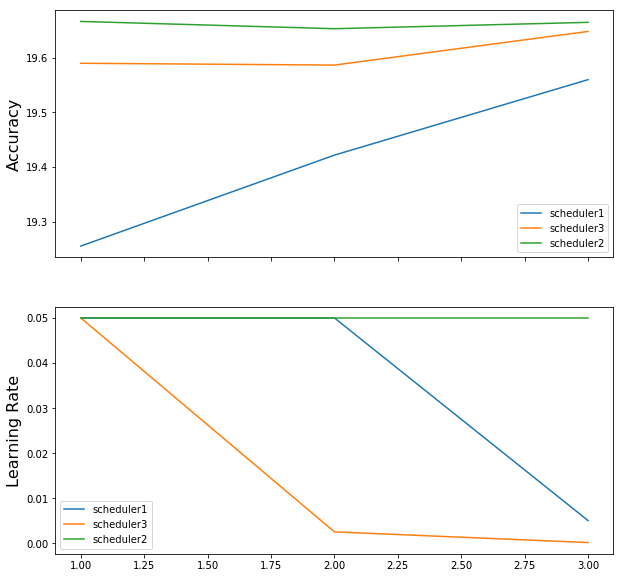

In [11]:
from matplotlib import gridspec
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import MultiStepLR

epochs = 3
momentum = .5
lr = .05

model = Net()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler1 = MultiStepLR(optimizer, milestones=[2,4,6,8], gamma=0.1)
scheduler2 = MultiStepLR(optimizer, milestones=[5], gamma=0.5)
scheduler3 = ExponentialLR(optimizer, gamma=0.05)

schedulers = {}
schedulers['scheduler1'] = scheduler1
schedulers['scheduler2'] = scheduler2
schedulers['scheduler3'] = scheduler3


optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_loss, valid_loss, valid_acc, test_loss, test_acc, lr_list = test_lr_schedules(model, optimizer, schedulers, 
                                                                            train, test, valid, epochs)